<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [24]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [25]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('../capstone_user_identification')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [26]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                              session_length=10):
    files = glob(path_to_csv_files + "/*.csv")

    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    sessions = []

    for i, file in tqdm(enumerate(sorted(files))):
        time_stamp_series = pd.read_csv(file).iloc[:, 0]
        time_stamp_df = time_stamp_series.to_frame()
        time_stamp_df.columns = ['column_name']
        time_dt = pd.to_datetime(time_stamp_df['column_name'])
        user_session = pd.read_csv(file).iloc[:, 1]
        
        cur_session = []
        cur_time = []
        index = 0

        while index < len(user_session):

            weekdays_lst, hours_lst = [], []
            for j in range(index, min(index + session_length, len(user_session))):
                cur_session.append(site_freq[user_session[j]][0])

                weekdays_lst.append(time_dt[j].weekday())
                hours_lst.append(time_dt[j].hour)
                cur_time.append(time_dt[j].hour * 3600 + time_dt[j].minute * 60 + time_dt[j].second)

            day = min(weekdays_lst)
            hour = min(hours_lst)

            time_diff = [cur_time[i] - cur_time[i - 1] for i in range(1, len(cur_time))]

            unique_sites = len([i for i in np.unique(cur_session)])

            while len(cur_session) < session_length:
                cur_session.append(0)
            while len(time_diff) < session_length - 1:
                time_diff.append(0)

            timespan = sum(time_diff)

            sessions.append(cur_session + time_diff + [timespan, unique_sites, hour, day, i + 1])

            index += session_length
            cur_session = []
            cur_time = []

    df = pd.DataFrame(sessions)
    df.columns = feature_names

    return df

In [27]:
def plotly_for_train_date(df):
    fig = make_subplots(rows=2, cols=2, subplot_titles=("session_timespan", "#unique_sites", "start_hour", "day_of_week"))

    fig.add_trace(
        go.Histogram(x=df['session_timespan'].tolist(), y=df['target'].tolist()),
        row=1, col=1
    )

    fig.add_trace(
        go.Box(x=df['#unique_sites'].tolist(), y=df['target'].tolist()),
        row=1, col=2
    )

    fig.add_trace(
        go.Histogram(x=df['start_hour'].tolist(), y=df['target'].tolist()),
        row=2, col=1
    )

    fig.add_trace(
        go.Box(x=df['day_of_week'].tolist(), y=df['target'].tolist()),
        row=2, col=2
    )

    fig.update_layout(height=700, width=800)
    fig.show()

In [28]:
# from sklearn.manifold import TSNE
# import plotly.express as px

# def tsne_3d(df):
#     features = df.loc[:, 'target':]
#     tsne = TSNE(n_components=3, random_state=0)
#     projections = tsne.fit_transform(features, )

#     fig = px.scatter_3d(
#         projections, x=0, y=1, z=2,
#         color=df.target, labels={'color': 'species'}
#     )
#     fig.update_traces(marker_size=8)
#     fig.show()

**Проверим функцию на игрушечном примере.**

In [29]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)


0it [00:00, ?it/s]

In [30]:
train_data_toy

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0     10      8      8      4      8      5      1      6      2       9   
1     10      5      5      5      0      0      0      0      0       0   
2     10      8      3      3      8      0      0      0      0       0   
3      7      5      8      5      8      5      5      6     11       7   
4      7      5      8      0      0      0      0      0      0       0   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0         287        1184        6278         186           2           1   
1           2           3          55           0           0           0   
2         287        1184        6278         186           0           0   
3         287        1184        6278         186           2           1   
4         287        1184           0           0           0           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           2           3          55              7998              8   
1           0           0           0                60              2   
2           0           0           0              7935              3   
3           2           3          55              7998              5   
4           0           0           0              1471              3   

   start_hour  day_of_week  target  
0           9            4       1  
1          12            4       1  
2           9            4       2  
3           9            4       3  
4          12            4       3

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [31]:
from time import time


t_start = time()
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)


print("Time elapsed", time() - t_start)

0it [00:00, ?it/s]

Time elapsed 5.741791009902954


In [32]:
train_data_10users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0   1314   2306   4318   4172   4318   4318   4172   4318   2455    4318   
1   4869   3050   2897    941   4318    206    252   1663   2354    3722   
2   3722   4172   3722   3722   4104   3069   4869   2906    993    3722   
3    370   1837    370   3722   3722   3722   3722   3589   3056     348   
4   2993   3722   4104   1659   2336   2915   1759    629   1063     629   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0          10           0           0           1          20           1   
1           1           0         163         105           0           1   
2           0          14           1         242           0           0   
3           2           1           0           1          25           1   
4           1           0           1           1           1           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           0           1           0                33              5   
1           3           3           8               284             10   
2           1           0           0               258              7   
3           0           0           0                30              6   
4           1           1           0                 6              9   

   start_hour  day_of_week  target  
0           8            4       1  
1           8            4       1  
2           8            4       1  
3           8            4       1  
4           8            4       1

In [33]:
plotly_for_train_date(train_data_10users)

In [37]:
# tsne_3d(train_data_10users)

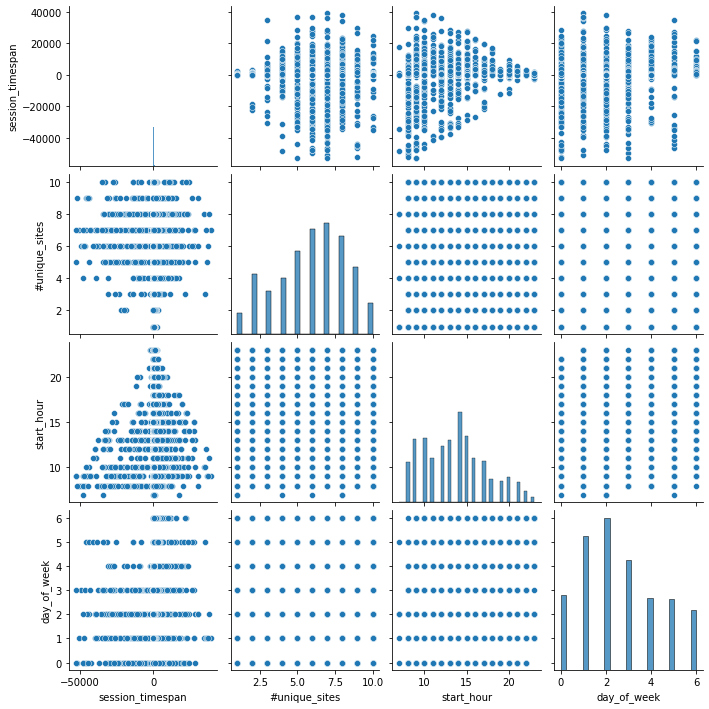

In [38]:
cols = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']
sns_plot = sns.pairplot(train_data_10users[cols])

In [39]:
columns_to_show = ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']

train_data_10users.groupby(['target'])[columns_to_show].agg([np.mean, np.std, np.min, np.max])

session_timespan                            #unique_sites            \
                   mean          std   amin   amax          mean       std   
target                                                                       
1             29.302632  3473.980036 -43641  20280      7.103947  1.956304   
2             -7.477495  2986.768619 -32635  18887      6.071429  2.129451   
3             -2.946461  2679.961044 -49404  34271      6.354356  2.580545   
4             -6.812968  4730.208222 -47130  28525      6.665835  2.355551   
5             50.352778  4128.207815 -50601  23190      5.436111  2.585684   
6             -4.250000  4166.843119 -53092  34974      6.038551  2.168185   
7            -17.306509  3429.732729 -46313  39049      4.611230  2.334957   
8             22.997859  4663.588048 -47758  36756      6.771413  1.844140   
9            -24.923311  3839.544996 -52592  23810      5.760195  2.010556   
10            27.838951  4971.274306 -44666  37905      6.496255  2.068024   

                 start_hour                     day_of_week                 \
       amin amax       mean       std amin amax        mean       std amin   
target                                                                       
1         1   10  12.772368  2.438065    8   23    2.725000  1.343272    0   
2         1   10  11.674168  2.702068    8   18    2.526419  1.331008    0   
3         1   10  10.793557  2.543232    8   23    1.724138  1.062349    0   
4         1   10  13.685786  3.428750    8   23    1.403990  1.760684    0   
5         1   10  14.115278  4.366937    7   23    3.981944  1.429262    1   
6         1   10  14.277453  3.179163    7   23    2.339953  1.570131    0   
7         1   10  15.886624  4.184521    8   23    3.760372  1.910469    0   
8         1   10  12.808887  2.447168    8   22    1.926124  1.395495    0   
9         1   10  14.992696  2.859043    8   23    2.779063  1.986066    0   
10        1   10  14.951311  3.364290    8   23    3.372659  1.826859    0   

             
       amax  
target       
1         5  
2         4  
3         4  
4         6  
5         6  
6         6  
7         6  
8         6  
9         6  
10        6

In [40]:
pd.crosstab(train_data_10users['start_hour'], train_data_10users['target'])

target       1    2    3    4   5    6    7    8    9    10
start_hour                                                 
7             0    0    0    0   2    5    0    0    0    0
8            16   77  415   99  64    9   40   92    6   15
9            51  165  430   96  86   78  209  145   45   14
10           94  256  468    1  52   47  234   84   53   35
11           90  102  269   13  49   70  111  106   69   40
12          115   60   38    2  52  230  154  418   72   32
13           76   44   71   33  21  332  140  250  294   39
14           98   57  280  157  44  357  145  408  296   36
15          144  164  130  217  53  172  174  180  101   44
16           26   54   84   54  97  114  158   72  140  120
17           44   40    8   37  44   87  235   57  237   58
18            1    3    0   61  18    5  189   29  140   35
19            0    0    0   10   9   27  262    0  120   17
20            1    0    4    3  47   58  345   13   30   11
21            2    0    4    4  54   35  266    9   13   27
22            0    0    2    9  17   39  122    5   17    6
23            2    0    1    6  11   47   12    0   10    5

In [41]:
pd.crosstab(train_data_10users['#unique_sites'], train_data_10users['target'])

target          1    2    3    4    5    6    7    8    9    10
#unique_sites                                                  
1               10   26  216   57    7   47   34    8   17    6
2                8   38   66   13  152   73  741   34  100   24
3               24   58   66   19   59  108  384   47  103   22
4               35  110  100   31   63  178  294  102  216   34
5               62  157  205   75   64  251  305  260  292   64
6              109  182  308  117   92  300  334  340  320   97
7              170  174  389  150   95  273  323  382  251  100
8              142  142  389  161   90  261  213  352  195  100
9              129   92  299  123   63  155  125  236  113   59
10              71   43  166   56   35   66   43  107   36   28

In [42]:
pd.crosstab(train_data_10users['day_of_week'], train_data_10users['target'])

target        1    2     3    4    5    6    7    8    9    10
day_of_week                                                   
0             86   54   396  314    0  250  137  162  160    9
1             63  288   329  240   11  313  363  744  405   42
2            109   73  1080  107  208  308  306  478  272  234
3            222  280   285   22    3  522  420  198  316   24
4            276  327   114   51  107  149  201  182   85    0
5              4    0     0    6  343  105  739   48  101  131
6              0    0     0   62   48   65  630   56  304   94

In [43]:
train_data_10users.pivot_table(['#unique_sites', 'start_hour', 'day_of_week', 'session_timespan'], 
['target'], aggfunc='mean')

#unique_sites  day_of_week  session_timespan  start_hour
target                                                          
1            7.103947     2.725000         29.302632   12.772368
2            6.071429     2.526419         -7.477495   11.674168
3            6.354356     1.724138         -2.946461   10.793557
4            6.665835     1.403990         -6.812968   13.685786
5            5.436111     3.981944         50.352778   14.115278
6            6.038551     2.339953         -4.250000   14.277453
7            4.611230     3.760372        -17.306509   15.886624
8            6.771413     1.926124         22.997859   12.808887
9            5.760195     2.779063        -24.923311   14.992696
10           6.496255     3.372659         27.838951   14.951311

**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [45]:
t_start = time()
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

print("Time elapsed", time() - t_start)

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
train_data_150users.head()

In [ ]:
plotly_for_train_date(train_data_150users)

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [46]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

NameError: name 'train_data_150users' is not defined

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

In [47]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
#train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [48]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0.5, 0, 'Длина сессии')

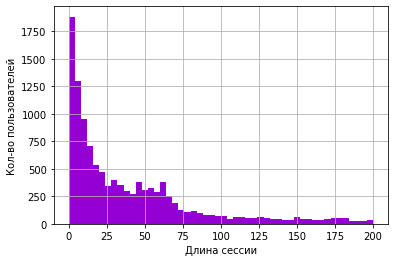

In [49]:
train_data_10users['session_timespan'].hist(color = 'darkviolet', bins=50, range=(0, 200))
plt.ylabel('Кол-во пользователей')
plt.xlabel('Длина сессии')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0.5, 0, 'Кол-во уникальных сайтов в одной сессии')

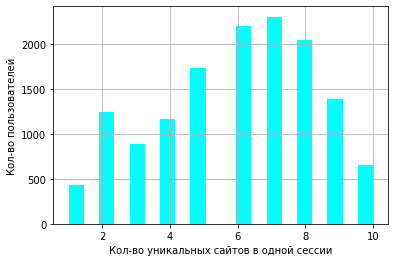

In [50]:
train_data_10users['#unique_sites'].hist(color = 'aqua', bins=20)
plt.ylabel('Кол-во пользователей')
plt.xlabel('Кол-во уникальных сайтов в одной сессии')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

In [51]:
def sub_plots(name_df, xlabel, xtick):
    user_ind = [user_index for user_index, df_ind in train_data_10users.groupby('target').groups.items()]
    user_sess = [df_ind for user_index, df_ind in train_data_10users.groupby('target').groups.items()]
    df_ind = [df_ind_values for df_ind_values, quantity_uniq_sites in
                           name_df.items()]
    quantity_uniq = [quantity_uniq_sites for df_ind_values, quantity_uniq_sites in
                                 name_df.items()]
    uniq_in_sess = []
    for _, lst in list(zip(user_ind, user_sess)):
        for count, uniq in list(zip(df_ind, quantity_uniq)):
            if count in lst:
                uniq_in_sess.append((_, uniq))

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 10), sharey=True)

    df = pd.DataFrame()
    for user in range(1, 11):
        df = df.append(pd.DataFrame({f'user_{user}': [i[1] for i in uniq_in_sess if i[0] == user]}))
    counter = 0
    for row in range(2):
        for col in range(5):
            ax = axes[row][col]
            if counter < len(df.columns):
                ax.hist(df[df.columns[counter]], bins=20,
                        color=[color_dic[id_name_dict[key]] for key, value in id_name_dict.items()][counter],
                        label='{}'.format([id_name_dict[key] for key, value in id_name_dict.items()][counter]))
                ax.set_xlabel(xlabel)
                ax.set_xticklabels(xtick)
                ax.set_ylabel('кол-во пользователей')
                leg = ax.legend(loc='upper left')
                leg.draw_frame(False)
            else:
                ax.set_axis_off()
            counter += 1

In [52]:
sub_plots(train_data_10users['#unique_sites'], 'кол-во уникальных сайтов', [2, 4, 6, 8, 10])

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

In [53]:
train_data_10users['start_hour'].hist(color = 'darkgreen', bins=20)
plt.ylabel('Кол-во пользователей')
plt.xlabel('Час начала')

Text(0.5, 0, 'Час начала')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

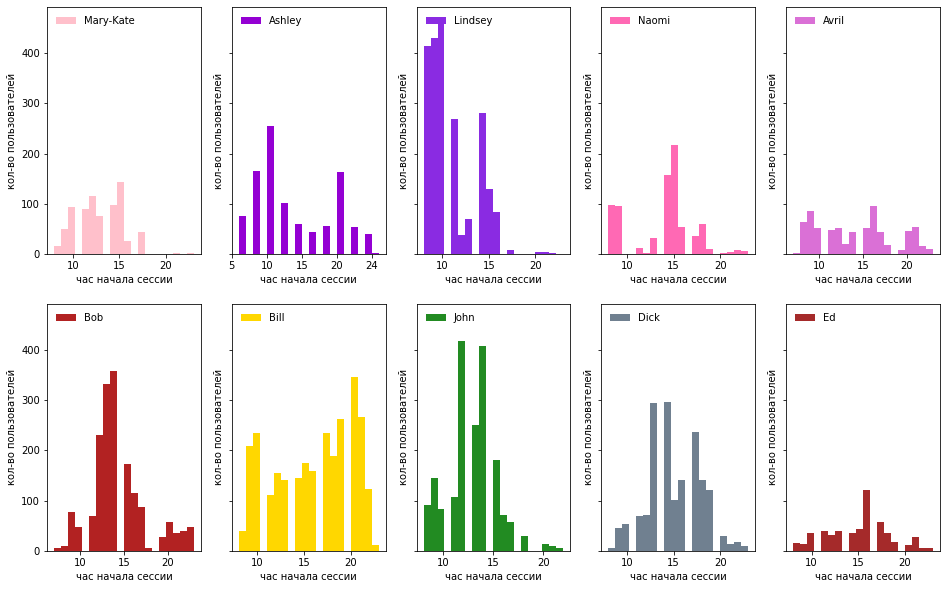

In [54]:
sub_plots(train_data_10users['start_hour'], 'час начала сессии', [5, 10, 15, 20, 24])

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

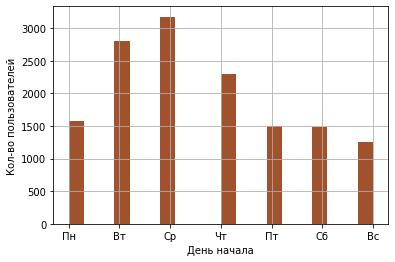

In [55]:
train_data_10users['day_of_week'].hist(color = 'sienna', bins=20)
plt.ylabel('Кол-во пользователей')
plt.xlabel('День начала')
plt.xticks(np.arange(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

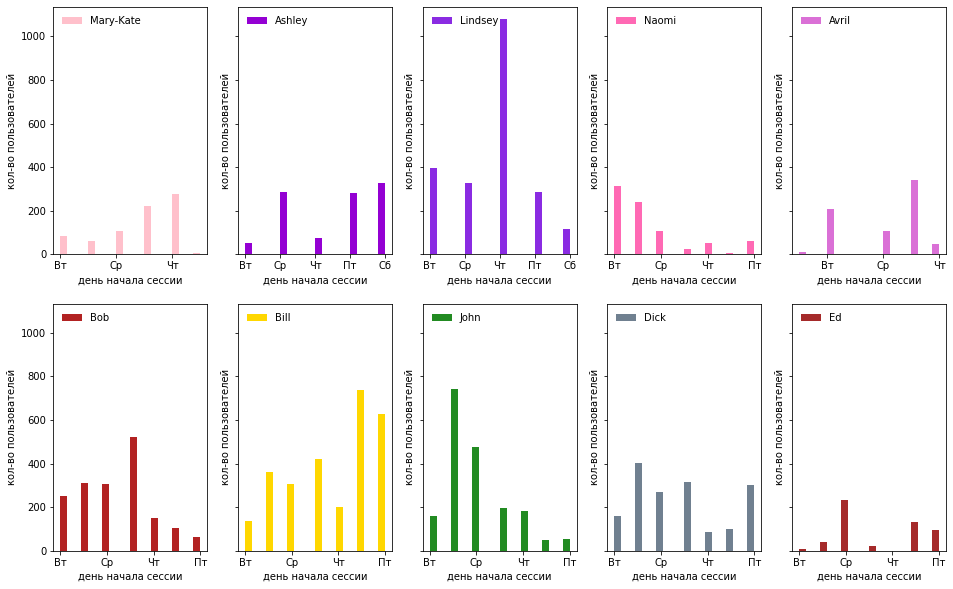

In [56]:
sub_plots(train_data_10users['day_of_week'], 'день начала сессии', ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Most common quantity of uniq sites: Mary-Kate - 9, Ashley - 8, Lindsey - 10, Naomi - 10, Avril - 4, Bob - 8, 
Bill - 4, John - 8, Dick - 9, Ed - 9

Most common hour for session's start: Mary-Kate - 16, Ashley - 11, Lindsey - 10, Naomi - 15, Avril - 17, Bob - 13, 
Bill - 21, John - 12, Dick - 13, Ed - 16

Most day of week for session's start: Mary-Kate - Thursday, Ashley - Saturday, Lindsey - Thursday, Naomi - Tuesday, Avril - Thursday, Bob - Wednesday, Bill - Thursday, John - Wednesday, Dick - Wednesday, Ed - Wednesday

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [57]:
with open('../capstone_user_identification/site_freq_10users.pkl', 'rb') as f:
    site_freq = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (top10_sites) и соответствующие кол-ва посещений (top10_freqs)**

In [58]:
top10_sites, top10_freqs = [], []
new_dict = {}
for i, j in site_freq.items():
    new_dict[j[1]] = i
sorted_dt = {key: value for key, value in sorted(new_dict.items(), key=lambda item: item[0])}
for i, j in enumerate(reversed(sorted_dt.items())):
    if i < 10:
        top10_sites.append(j[1])
        top10_freqs.append(j[0])
df_sites = pd.DataFrame({'sites':top10_sites, 'freqs':top10_freqs})

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

<AxesSubplot:xlabel='freqs', ylabel='sites'>

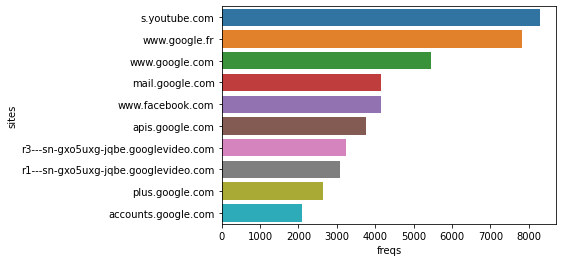

In [59]:
sns.barplot(x="freqs", y="sites", data=df_sites)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [60]:
print(train_data_10users['session_timespan'].median())

33.0


**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [61]:
print(train_data_10users['day_of_week'].median())

2.0


**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [62]:
print(train_data_150users['start_hour'].median())

NameError: name 'train_data_150users' is not defined

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [63]:
print(train_data_150users['#unique_sites'].median())

NameError: name 'train_data_150users' is not defined

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [56]:
selected_features_10users = train_data_10users[['session_timespan', '#unique_sites']]
selected_features_150users = train_data_150users[['session_timespan', '#unique_sites']] 

In [57]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 